**GEOMETRIC BROWNIAN MOTION**

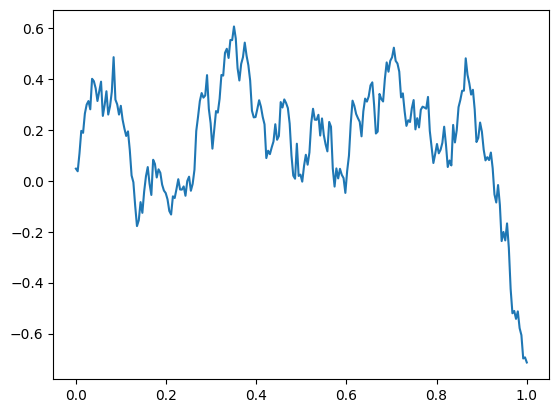

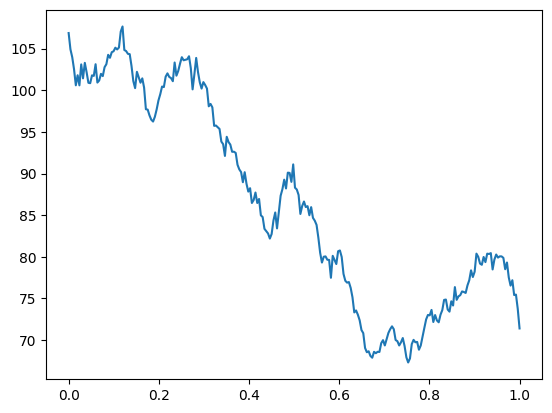

In [1]:
import numpy as np
import matplotlib.pyplot as plt

def Weiner_process(dt):
    return np.random.normal(0,1)*dt**(1/2)

def Brownian_motion(T,dt = 1/252):
    n = int(1/dt)
    X = np.linspace(0,T,n)
    return X,np.cumsum([Weiner_process(dt) for _ in range(n)])
    
X,z = Brownian_motion(1)
plt.plot(X,z)
plt.show()

def GBM(mu,S0,sigma,T):
    X,W = Brownian_motion(T)
    return X,S0*np.exp((mu-1/2*sigma**2)*T+sigma*W)

X,S = GBM(0.1,100,0.2,1)
plt.plot(X,S)
plt.show()

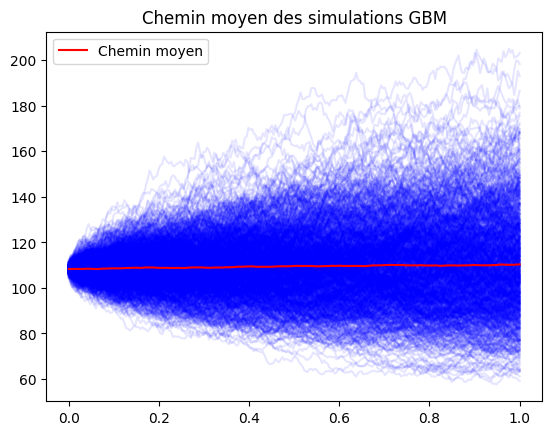

In [2]:
paths = []
for _ in range(1000):
    X,S = GBM(0.1,100,0.2,1)
    paths.append(S)
    plt.plot(X, S, color='blue', alpha=0.1)
plt.title("Simulation des chemins GBM")
res = []
for k in range(len(paths[0])):
    S_k = np.mean([S[k] for S in paths])
    res.append(S_k)
plt.plot(X, res, color='red', label='Chemin moyen')
plt.title("Chemin moyen des simulations GBM")
plt.legend()
plt.show()


In [3]:
import numpy as np
import scipy.stats as si
import matplotlib.pyplot as plt

# Black-Scholes pricing function for a European Call option
def black_scholes_call(S, K, T, r, sigma):
    d1 = (np.log(S / K) + (r + 0.5 * sigma ** 2) * T) / (sigma * np.sqrt(T))
    d2 = d1 - sigma * np.sqrt(T)
    call_price = S * si.norm.cdf(d1) - K * np.exp(-r * T) * si.norm.cdf(d2)
    delta = si.norm.cdf(d1)
    return call_price, delta

In [4]:
import numpy as np
import scipy.stats as si
import matplotlib.pyplot as plt
import ipywidgets as widgets
from ipywidgets import interactive

# Function to update the plot
def update(K=100, T=1, r=0.05, sigma=0.2):
    S_range = np.linspace(50, 150, 100)
    prices = []
    deltas = []
    
    for s in S_range:
        price, delta = black_scholes_call(s, K, T, r, sigma)
        prices.append(price)
        deltas.append(delta)
    
    fig, ax1 = plt.subplots()
    ax2 = ax1.twinx()
    
    ax1.plot(S_range, prices, 'b-', label='Option Price')
    ax2.plot(S_range, deltas, 'r-', label='Delta')
    
    ax1.set_xlabel('Stock Price (S)')
    ax1.set_ylabel('Option Price', color='b')
    ax2.set_ylabel('Delta', color='r')
    
    ax1.tick_params(axis='y', colors='b')
    ax2.tick_params(axis='y', colors='r')
    
    plt.title('Black-Scholes Option Pricing & Delta')
    plt.show()

# Create interactive sliders
interactive_plot = interactive(update, 
                               K=widgets.FloatSlider(min=50, max=150, step=1, value=100, description='K'),
                               T=widgets.FloatSlider(min=0.1, max=5, step=0.1, value=1, description='T'),
                               r=widgets.FloatSlider(min=0, max=0.2, step=0.01, value=0.05, description='r'),
                               sigma=widgets.FloatSlider(min=0.05, max=1, step=0.05, value=0.2, description='sigma'))

interactive_plot

interactive(children=(FloatSlider(value=100.0, description='K', max=150.0, min=50.0, step=1.0), FloatSlider(va…

In [5]:
def delta_hedging(r,S0,sigma,T,K,mu,dt = 1/252):
    _, S = GBM(mu,S0,sigma,T)
    call_price, delta = black_scholes_call(S0, K, T, r, sigma)
    initial_cash = -delta*S0 + call_price
    portfolio_value = initial_cash
    deltas = [delta]
    for k in range(1,len(S)):
        call_price, delta = black_scholes_call(S[k], K, T-k*dt, r, sigma)
        deltas.append(delta)
        portfolio_value = delta*S[k] + initial_cash*np.exp(r*(T-k*dt))
    final_portfolio_value = portfolio_value - max(S[-1]-K,0)
    return final_portfolio_value
r,S0,sigma,T,K,mu = 0.05, 100,0.2, 1, 100, 0.08
delta_hedging(r,S0,sigma,T,K,mu,dt = 1/252)

46.75695540643024

0.29479154603734314


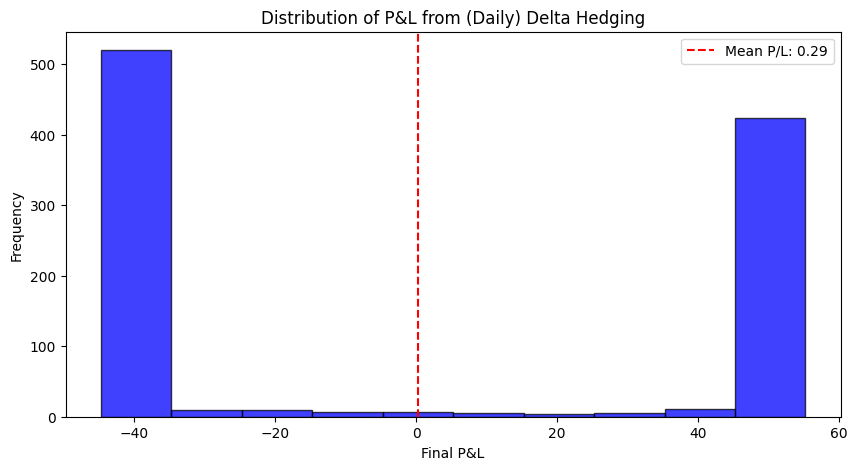

In [6]:
r,S0,sigma,T,K,mu = 0.05, 100,0.4, 1, 100, 0.05
pnl_list = []
for _ in range(1000):
    _, S = GBM(mu,S0,sigma,T)
    pnl = delta_hedging(r,S0,sigma,T,K,mu,dt = 1/252)
    pnl_list.append(pnl)

print(np.mean(pnl_list))
plt.figure(figsize=(10, 5))
plt.hist(pnl_list, bins=10, alpha=0.75, color="blue", edgecolor="black")
plt.axvline(np.mean(pnl_list), color='r', linestyle="--", label=f"Mean P/L: {(np.mean(pnl_list)).round(2)}")
plt.title("Distribution of P&L from (Daily) Delta Hedging")
plt.xlabel("Final P&L")
plt.ylabel("Frequency")
plt.legend()
plt.show()
    

8.479893957049644


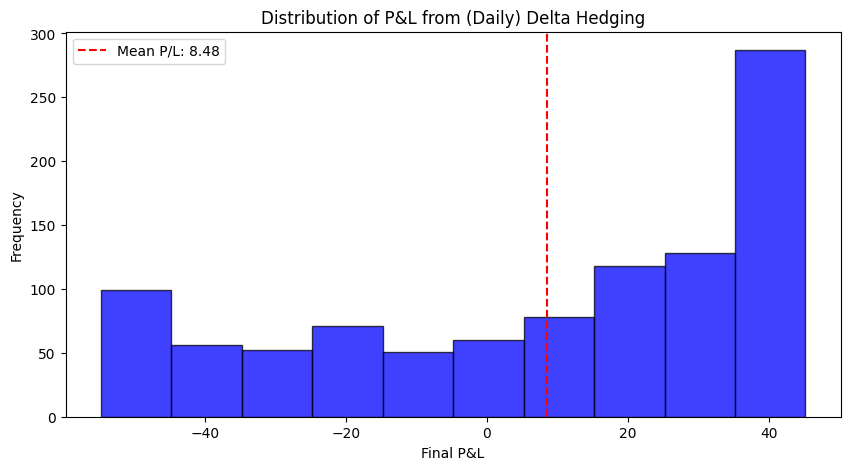

In [7]:
def BS_call_gamma(S, K, T, r, sigma):
    d1 = (np.log(S / K) + (r + 0.5 * sigma ** 2) * T) / (sigma * np.sqrt(T))
    d2 = d1 - sigma * np.sqrt(T)
    call_price = S * si.norm.cdf(d1) - K * np.exp(-r * T) * si.norm.cdf(d2)
    delta = si.norm.cdf(d1)  
    gamma = ( (1 / np.sqrt(2 * np.pi)) * np.exp(-0.5 * d1**2) ) / (S*sigma*T**0.5)
    return call_price, delta, gamma

def delta_gamma_hedging(r,S0,sigma,T,K,mu,dt):
    _, S = GBM(mu,S0,sigma,T)
    call_price, delta, gamma = BS_call_gamma(S0, K, T, r, sigma)
    initial_cash = -delta*S0 - 0.5*gamma*dt*(S0**2)  + call_price
    portfolio_value = initial_cash
    deltas = [delta]
    gammas = [gamma]
    for k in range(1,len(S)):
        call_price, delta, gamma = BS_call_gamma(S[k], K, T-k*dt, r, sigma)
        deltas.append(delta)
        gammas.append(gamma)
        portfolio_value = delta*S[k] + 0.5*gamma*(S[k]**2)*dt + initial_cash*np.exp(r*(T-k*dt))
    final_portfolio_value = portfolio_value - max(S[-1]-K,0)
    return final_portfolio_value


r,S0,sigma,T,K,mu = 0.05, 100,0.2, 1, 100, 0.08
delta_gamma_hedging(r,S0,sigma,T,K,mu,dt = 0.5/252)
pnl_list = []
for _ in range(1000):
    _, S = GBM(mu,S0,sigma,T)
    pnl = delta_gamma_hedging(r,S0,sigma,T,K,mu,dt = 0.5/252)
    pnl_list.append(pnl)

print(np.mean(pnl_list))
plt.figure(figsize=(10, 5))
plt.hist(pnl_list, bins=10, alpha=0.75, color="blue", edgecolor="black")
plt.axvline(np.mean(pnl_list), color='r', linestyle="--", label=f"Mean P/L: {(np.mean(pnl_list)).round(2)}")
plt.title("Distribution of P&L from (Daily) Delta Hedging")
plt.xlabel("Final P&L")
plt.ylabel("Frequency")
plt.legend()
plt.show()
    

12.074012209176123


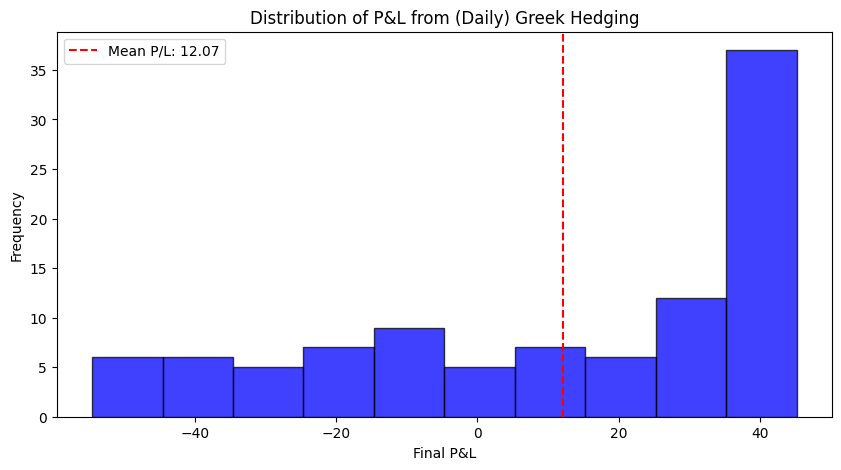

In [8]:
import numpy as np
import scipy.stats as si
import matplotlib.pyplot as plt

# Fonction BS Call avec calcul des grecs
def BS_call_greeks(S, K, T, r, sigma):
    d1 = (np.log(S / K) + (r + 0.5 * sigma ** 2) * T) / (sigma * np.sqrt(T))
    d2 = d1 - sigma * np.sqrt(T)
    call_price = S * si.norm.cdf(d1) - K * np.exp(-r * T) * si.norm.cdf(d2)
    # Delta
    delta = si.norm.cdf(d1)    
    # Gamma
    gamma = (1 / (S * sigma * np.sqrt(T))) * (1 / np.sqrt(2 * np.pi)) * np.exp(-0.5 * d1**2)    
    # Theta
    theta = (-S * si.norm.pdf(d1) * sigma) / (2 * np.sqrt(T)) - r * K * np.exp(-r * T) * si.norm.cdf(d2)   
    # Vega
    vega = S * np.sqrt(T) * si.norm.pdf(d1)   
    # Rho
    rho = K * T * np.exp(-r * T) * si.norm.cdf(d2)
    return call_price, delta, gamma, theta, vega, rho

# Fonction de couverture avec tous les grecs
def hedge_all_greeks(r, S0, sigma, T, K, mu, dt):
    _, S = GBM(mu, S0, sigma, T)
    call_price, delta, gamma, theta, vega, rho = BS_call_greeks(S0, K, T, r, sigma)

    initial_cash = -delta * S0 - 0.5 * gamma * dt * (S0 ** 2) + call_price
    portfolio_value = initial_cash
    
    # Listes pour stocker les valeurs des grecs
    deltas = [delta]
    gammas = [gamma]
    thetas = [theta]
    vegas = [vega]
    rhos = [rho]
    
    # Boucle pour chaque instant temporel
    for k in range(1, len(S)):
        call_price, delta, gamma, theta, vega, rho = BS_call_greeks(S[k], K, T - k * dt, r, sigma)
        
        deltas.append(delta)
        gammas.append(gamma)
        thetas.append(theta)
        vegas.append(vega)
        rhos.append(rho)
        
        portfolio_value = delta * S[k] + 0.5 * gamma * (S[k] ** 2) * dt + initial_cash * np.exp(r * (T - k * dt)) - theta * dt + vega * (sigma * dt)
    
    final_portfolio_value = portfolio_value - max(S[-1] - K, 0)
    return final_portfolio_value

# Paramètres
r, S0, sigma, T, K, mu = 0.05, 100, 0.2, 1, 100, 0.08

# Test du calcul pour un seul cas
hedge_all_greeks(r, S0, sigma, T, K, mu, dt=1 / 252)

# Simulation Monte Carlo sur 1000 chemins
pnl_list = []
for _ in range(100):
    _, S = GBM(mu, S0, sigma, T)
    pnl = hedge_all_greeks(r, S0, sigma, T, K, mu, dt=1 / 252)
    pnl_list.append(pnl)

# Affichage des résultats
print(np.mean(pnl_list))
plt.figure(figsize=(10, 5))
plt.hist(pnl_list, bins=10, alpha=0.75, color="blue", edgecolor="black")
plt.axvline(np.mean(pnl_list), color='r', linestyle="--", label=f"Mean P/L: {(np.mean(pnl_list)).round(2)}")
plt.title("Distribution of P&L from (Daily) Greek Hedging")
plt.xlabel("Final P&L")
plt.ylabel("Frequency")
plt.legend()
plt.show()


**A COMPARISON OF HEDGING STRATEGIES**

delta : 11.282186617588438
delta gamma : 13.879756328473558
all greeks : 8.678336526394407


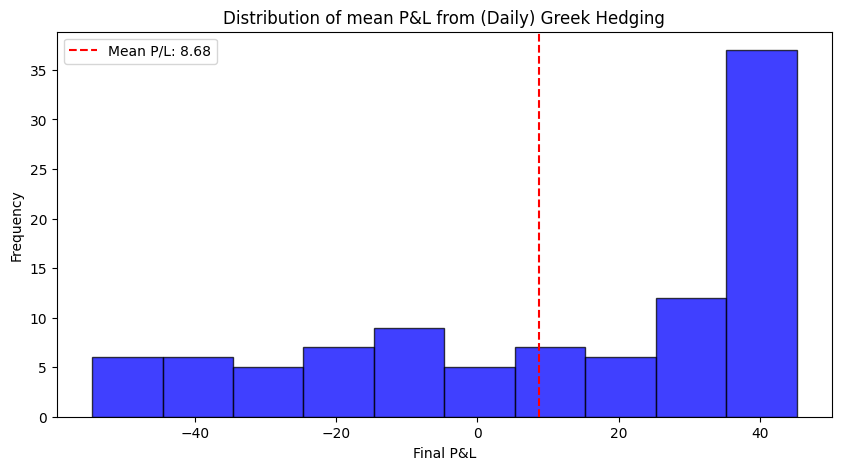

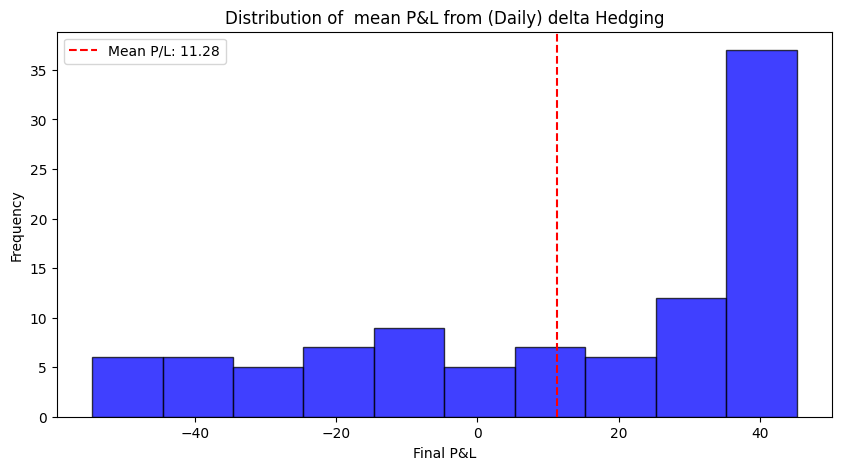

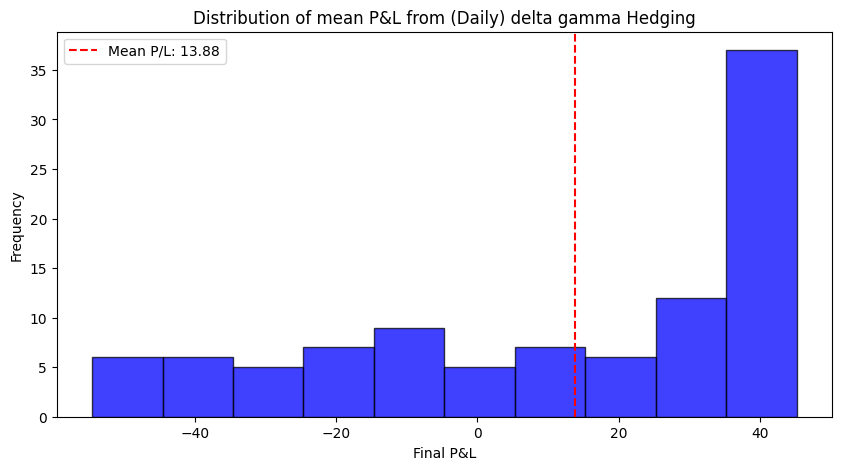

In [10]:
def fall_greeks():
    r, S0, sigma, T, K, mu = 0.05, 100, 0.2, 1, 100, 0.08
    pnl_list = []
    for _ in range(10):
        _, S = GBM(mu, S0, sigma, T)
        pnl = hedge_all_greeks(r, S0, sigma, T, K, mu, dt=1 / 252)
        pnl_list.append(pnl)
    return np.mean(pnl_list)

def fdelta():
    r, S0, sigma, T, K, mu = 0.05, 100, 0.2, 1, 100, 0.08
    pnl_list = []
    for _ in range(10):
        _, S = GBM(mu, S0, sigma, T)
        pnl = delta_hedging(r, S0, sigma, T, K, mu, dt=1 / 252)
        pnl_list.append(pnl)
    return np.mean(pnl_list)

def fdelta_gamma():
    r, S0, sigma, T, K, mu = 0.05, 100, 0.2, 1, 100, 0.08
    pnl_list = []
    for _ in range(10):
        _, S = GBM(mu, S0, sigma, T)
        pnl = delta_gamma_hedging(r, S0, sigma, T, K, mu, dt=1 / 252)
        pnl_list.append(pnl)
    return np.mean(pnl_list)

delta = []
delta_gamma = []
all_greeks = []

for _ in range(10):
    delta.append(fdelta())
    delta_gamma.append(fdelta_gamma())
    all_greeks.append(fall_greeks())

print(f"delta : {np.mean(delta)}")
print(f"delta gamma : {np.mean(delta_gamma)}")
print(f"all greeks : {np.mean(all_greeks)}")

plt.figure(figsize=(10, 5))
plt.hist(pnl_list, bins=10, alpha=0.75, color="blue", edgecolor="black")
plt.axvline(np.mean(all_greeks), color='r', linestyle="--", label=f"Mean P/L: {(np.mean(all_greeks)).round(2)}")
plt.title("Distribution of mean P&L from (Daily) Greek Hedging")
plt.xlabel("Final P&L")
plt.ylabel("Frequency")
plt.legend()
plt.show()

plt.figure(figsize=(10, 5))
plt.hist(pnl_list, bins=10, alpha=0.75, color="blue", edgecolor="black")
plt.axvline(np.mean(delta), color='r', linestyle="--", label=f"Mean P/L: {(np.mean(delta)).round(2)}")
plt.title("Distribution of  mean P&L from (Daily) delta Hedging")
plt.xlabel("Final P&L")
plt.ylabel("Frequency")
plt.legend()
plt.show()

plt.figure(figsize=(10, 5))
plt.hist(pnl_list, bins=10, alpha=0.75, color="blue", edgecolor="black")
plt.axvline(np.mean(delta_gamma), color='r', linestyle="--", label=f"Mean P/L: {(np.mean(delta_gamma)).round(2)}")
plt.title("Distribution of mean P&L from (Daily) delta gamma Hedging")
plt.xlabel("Final P&L")
plt.ylabel("Frequency")
plt.legend()
plt.show()
    
    

**ADJUSTING M TIMES A DAY**

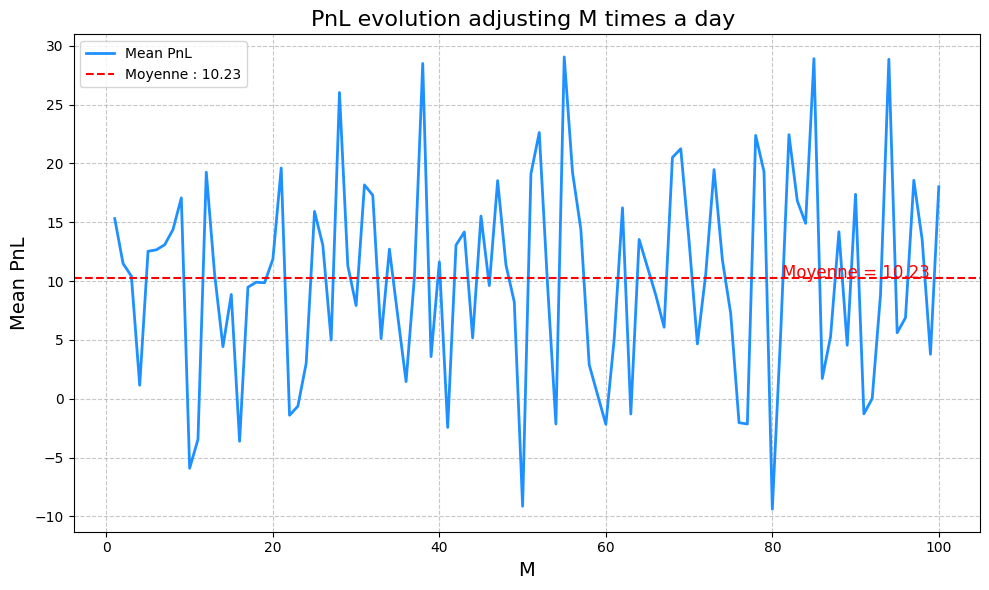

In [18]:
def gdelta(dt):
    r, S0, sigma, T, K, mu = 0.05, 100, 0.2, 1, 100, 0.08
    pnl_list = []
    for _ in range(10):
        _, S = GBM(mu, S0, sigma, T)
        pnl = delta_hedging(r, S0, sigma, T, K, mu, dt)
        pnl_list.append(pnl)
    return np.mean(pnl_list)

r, S0, sigma, T, K, mu = 0.05, 100, 0.2, 1, 100, 0.08
M = 100
results = []
for k in range(1,M+1):
    mean_pnl = gdelta(1/(252*M))
    results.append(mean_pnl)
mean_result = np.mean(results)

X = [k for k in range(1,M+1)]

plt.figure(figsize=(10, 6))
plt.plot(X, results, label="Mean PnL", color='dodgerblue', linewidth=2)
plt.axhline(mean_result, color='red', linestyle='--', label=f'Moyenne : {mean_result:.2f}')
plt.text(M * 0.9, mean_result + 0.05, f"Moyenne = {mean_result:.2f}", color="red", fontsize=12, ha="center")
plt.title("PnL evolution adjusting M times a day ", fontsize=16)
plt.xlabel("M", fontsize=14)
plt.ylabel("Mean PnL", fontsize=14)
plt.grid(True, linestyle="--", alpha=0.7)
plt.legend()
plt.tight_layout()
plt.show()

    
    
    